In [194]:
from collections import OrderedDict, Counter
import glob
import html
import math
import os
import re
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import GloVe

import numpy as np
import pandas as pd
from pandas import option_context
from sklearn.model_selection import train_test_split
from sklearn.metrics  import f1_score, recall_score, precision_score

import preprocessor as tweetpreprocessor
from nltk import RegexpTokenizer

from tqdm import tqdm
from tabulate import tabulate
import wandb
import seaborn as sns
from IPython.display import Image
import ipyplot

import matplotlib.pyplot as plt
%matplotlib inline

# NLP Disaster Tweets

In this project we participate in the Kaggle task [NLP Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/).  The task is to identify whether a tweet is about a natural disaster or not. This is a binary classification task - 1 indicates it is, 0 indicates that it's not.

It is also a Natural Language Processing (NLP) task in that the primary feature is text (a tweet message.)

The Kaggle competition provides a training set and a test set.  The training set has 7,613 examples while the test set has 3,263 examples.

Both sets have the following features:
- tweet id
- tweet text
- keyword from the tweet (possibly blank)
- location from which the tweet was made (possibly blank)

The training set has target labels (0 or 1), while the test set does not.

# EDA

Let's load and do EDA on just the training data since we are pretending not to know anything about the test data.

In [2]:
train_df = pd.read_csv('twitter_disaster/train.csv')

In [3]:
len(train_df)

7613

Let's look at a random sample of the data.   The text field is the primary feature. It contains hashtags like #Buffalo and #LiveOnK2, mentions like @NASAHurricane, URLs and in general lots of non-alphanumeric characters.

In [4]:
with option_context('display.max_colwidth', 200):
    display(train_df.sample(10, random_state=7))

,id,keyword,location,text,target
6106,8718,sinking,NaN,If there's a chance will get a gander of the sinking ship that is #TNA too. Can't help but appease my morbid curiosity. #DestinationIMPACT,0
5025,7166,mudslide,"Chiswick, London",2 great new recipes; mudslide cake and so sorry stew! #GBBO,0
7022,10066,typhoon,USA,#breaking #news Global precipitation measurement satellite captures 3-D image of Typhoon Soudelor - @NASAHurricane http://t.co/20DNcthr4D,1
2331,3355,demolition,USA,EPA begins demolition of homes in toxic area #Buffalo - http://t.co/noRkXBRS6G,1
3354,4800,evacuated,"Hensley Street, Portland",KATUNews: #SR14 remains closed as brush fire burns 1700 acres: http://t.co/QposKp3MWj #LiveOnK2 http://t.co/mTQjsvupwy,1
6117,8733,sinking,London,Spent too many hours sinking into the wonderfully created worlds of Mafia and Mafia II in my life. Excited for another installment.,0
2258,3237,deluged,NaN,Businesses are deluged with invoices. Make yours stand oup with colour or shame and it's likely to rise to the top of the pay' pile.,0
2801,4028,disaster,In Your Notifications,@Hollyorange8 my day has been a disaster of emotions,0
3666,5220,fatality,NaN,Hibernating pbx irrespective of pitch fatality careerism pan: crbZFZ,0
5984,8545,screams,xiumin's nonexistent solos,//screams in the distance// http://t.co/Cfe9HUQN0h,1


We should clean this text by removing URLs, removing non-ahphanumeric characters and lowercasing.  We will use the library [tweet-preprocessor](https://pypi.org/project/tweet-preprocessor/) for removing URLs and emojis.  It will also remove hashtags and mentions, but let's keep those for now and just use a regular expression tokenizer for removing non-alphanumeric characters.

In [7]:
tweetpreprocessor.set_options(tweetpreprocessor.OPT.URL, tweetpreprocessor.OPT.EMOJI)
tokenizer = RegexpTokenizer(r'\w+')

def clean_text(text):
    text = re.sub('%20', ' ', text)
    text = html.unescape(text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = tweetpreprocessor.clean(text)
    tokens = [t.lower() for t in tokenizer.tokenize(text) if not t.isnumeric()]
    text = ' '.join(tokens)
    return text

In [8]:
train_df['clean_text'] = train_df.text.apply(clean_text)

In [9]:
with option_context('display.max_colwidth', 200):
    display(train_df.sample(10, random_state=7).clean_text)

6106    if there s a chance will get a gander of the sinking ship that is tna too can t help but appease my morbid curiosity destinationimpact
5025                                                                                    great new recipes mudslide cake and so sorry stew gbbo
7022                               breaking news global precipitation measurement satellite captures d image of typhoon soudelor nasahurricane
2331                                                                                      epa begins demolition of homes in toxic area buffalo
3354                                                                           katunews sr14 remains closed as brush fire burns acres liveonk2
6117         spent too many hours sinking into the wonderfully created worlds of mafia and mafia ii in my life excited for another installment
2258         businesses are deluged with invoices make yours stand oup with colour or shame and it s likely to rise to the top of the pay pile

This looks ok.  Now that we have our text data in a cleaned up form, let's analyze it.  First of all, do we have any duplicates?

In [10]:
n_duplicates = len(train_df[train_df['clean_text'].duplicated()])
p = 100*n_duplicates/len(train_df)
print(f"{n_duplicates} records have duplicated text ({p:.3}%)")

740 records have duplicated text (9.72%)


Wow - almost 10% of the training set has duplicates.  What are they?  It looks like the most common dupe is 'watch this airport get swallowed up by a sandstorm in under a minute'

In [11]:
text_ctr = Counter([t for t in train_df.clean_text])
dupes = [(t,c) for t,c  in text_ctr.most_common() if c > 1]
table = [['# of dupes', 'text']]
for t, c in dupes[:10]:
    table.append([c, t])
print(tabulate(table))

----------  -----------------------------------------------------------------------------------------------------------------------------
# of dupes  text
24          watch this airport get swallowed up by a sandstorm in under a minute
20          wreckage conclusively confirmed as from mh370 malaysia pm investigators and the families of those who were
19          families to sue over legionnaires more than families affected by the fatal outbreak of legionnaires disea
17          hot funtenna hijacking computers to send data as sound waves prebreak best
15          christian attacked by muslims at the temple mount after waving israeli flag via pamela geller
13          obama declares disaster for typhoon devastated saipan obama signs disaster declaration for northern marians a
13          the latest more homes razed by northern california wildfire abc news
11          pandemonium in aba as woman delivers baby without face photos
10          years after atomic bombs japan still struggle

I thought maybe they were tweets with multiple keywords but this doesn't seem to be the case.

In [12]:
len(train_df[train_df[['keyword', 'clean_text']].duplicated()])

705

It looks like they may be associated with different URLs and locations

In [13]:
train_df[train_df[['keyword', 'clean_text']].duplicated()]

,id,keyword,location,text,target,clean_text
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,check these out nsfw
106,156,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0,icemoon djicemoon dubstep trapmusic dnb edm da...
114,164,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/M4...,0,icemoon djicemoon dubstep trapmusic dnb edm da...
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0,icemoon djicemoon dubstep trapmusic dnb edm da...
116,168,aftershock,NaN,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/e1...,0,icemoon djicemoon dubstep trapmusic dnb edm da...
...,...,...,...,...,...,...
7538,10777,wreckage,NaN,Wreckage 'Conclusively Confirmed' as From MH37...,1,wreckage conclusively confirmed as from mh370 ...
7539,10779,wreckage,Maharashtra,Wreckage 'Conclusively Confirmed' as From MH37...,1,wreckage conclusively confirmed as from mh370 ...
7540,10780,wreckage,Mumbai,Wreckage 'Conclusively Confirmed' as From MH37...,1,wreckage conclusively confirmed as from mh370 ...
7541,10782,wreckage,"New Delhi,India",Wreckage 'Conclusively Confirmed' as From MH37...,1,wreckage conclusively confirmed as from mh370 ...


Regardless, let's get rid of at least tweets with the same cleaned text and keyword.

In [14]:
train_no_dupes_df = train_df.drop_duplicates(['keyword', 'clean_text'], keep='first')

In [15]:
train_no_dupes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6908 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          6908 non-null   int64 
 1   keyword     6847 non-null   object
 2   location    4637 non-null   object
 3   text        6908 non-null   object
 4   target      6908 non-null   int64 
 5   clean_text  6908 non-null   object
dtypes: int64(2), object(4)
memory usage: 377.8+ KB


In [16]:
print(f"The original train dataset had {len(train_df)} records, now we have {len(train_no_dupes_df)}, a difference of {len(train_df)-len(train_no_dupes_df)}.")

The original train dataset had 7613 records, now we have 6908, a difference of 705.


Now that we have cleaned the tweets, let's analyze the data.  What is the distribution of the document lengths?

In [17]:
text_lengths = train_no_dupes_df.clean_text.apply(lambda x: len(x.split()))
text_lengths.describe()

count    6908.000000
mean       14.192530
std         6.080822
min         1.000000
25%        10.000000
50%        14.000000
75%        18.000000
max        33.000000
Name: clean_text, dtype: float64

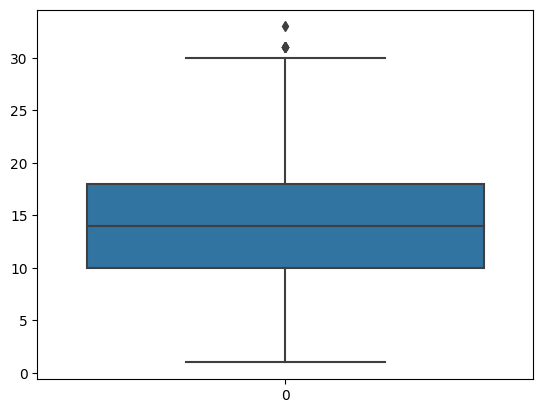

In [18]:
sns.boxplot(text_lengths);

These are tweets, so the text is short.  This is good for RNNs and the LSTM and GRU variants we will use below.

Thera are 18 tweets that consist of 1 word, for example 'LOOOOOOL' and 'Flooding'.  Just keep these for now as it seems reasonable that tweets would often be just one word.

In [19]:
one_word_tweets = train_no_dupes_df[train_no_dupes_df.clean_text.apply(lambda x: len(x.split()) <= 1)]; len(one_word_tweets)

18

In [20]:
one_word_tweets

,id,keyword,location,text,target,clean_text
24,36,NaN,NaN,LOOOOOOL,0,looooool
28,40,NaN,NaN,Cooool :),0,cooool
113,163,aftershock,Belgium,Aftershock https://t.co/xMWODFMtUI,0,aftershock
321,467,armageddon,Here And There,Armageddon https://t.co/uCSUDk3q1d,1,armageddon
820,1191,blizzard,NaN,Stats http://t.co/U7vavyrGv9,0,stats
1882,2703,crushed,NaN,Crushed,0,crushed
2141,3073,deaths,Does it really matter!,Deaths 7 http://t.co/xRJA0XpL40,1,deaths
3667,5221,fatality,Nairobi,Fatality!,0,fatality
3883,5521,flattened,Mars,Flattened https://t.co/9jCIBenckz,0,flattened
3953,5620,flooding,NaN,Flooding ???? http://t.co/WVeO9ED10e,1,flooding


Is there a difference in the lengths between positive and negative targets?  Let's look at the number of characters.

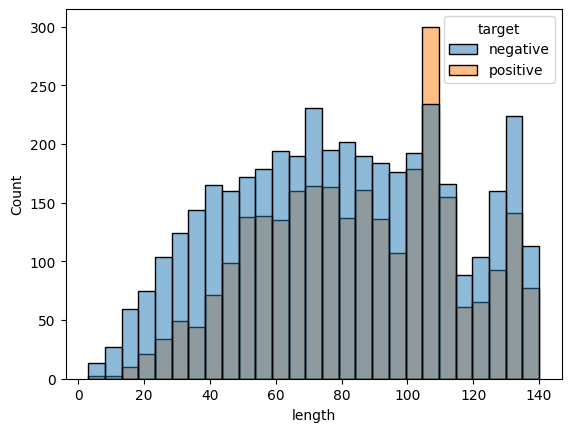

In [21]:
pos_tgt_text_lengths = train_no_dupes_df[train_no_dupes_df.target == 1].clean_text.apply(lambda x: len(x))
neg_tgt_text_lengths = train_no_dupes_df[train_no_dupes_df.target == 0].clean_text.apply(lambda x: len(x))
plotdf = pd.DataFrame({'length': list(neg_tgt_text_lengths)+list(pos_tgt_text_lengths),
                       'target': ['negative']*len(neg_tgt_text_lengths) + ['positive']*len(pos_tgt_text_lengths)})
sns.histplot(data=plotdf, x="length", hue="target");

There are more negative examples than positive ones but the shape of the distributions are similar.  How many examples do we have for each target?  It looks like we have more negative examples than positive examples but not enough to sample differently when modeling below.

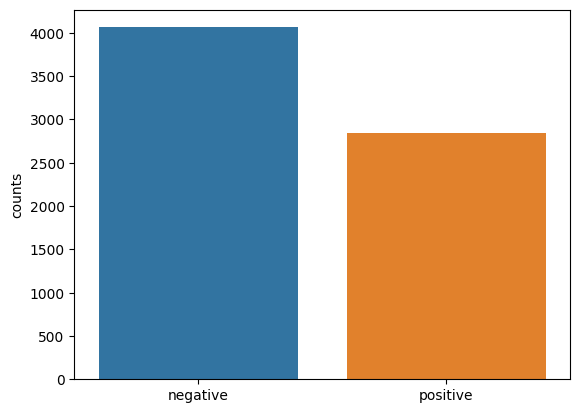

In [22]:
target_df = pd.DataFrame({'target': ['negative', 'positive'], 'counts': [len(neg_tgt_text_lengths), len(pos_tgt_text_lengths)]})
chart = sns.barplot(data=target_df, x="target", y="counts")
chart.set(xlabel=None);

What does the word distribution for each target look like?  Let's look at the top 50 common words for each.

In [23]:
def display_top_words(tgt_val, tgt_label):
    topk = 50
    vocab_ctr = Counter([w for doc in train_no_dupes_df[train_no_dupes_df.target == tgt_val].clean_text for w in doc.split()])
    words, freq = zip(*vocab_ctr.most_common()[:topk])

    df = pd.DataFrame({'word': words, 'freq': freq})
    plt.figure(figsize=(12, 6))
    chart = sns.barplot(data=df, x='word', y='freq', color='steelblue')
    chart.set_title(f"Top {topk} words in all {tgt_label} tweets")
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    chart.set(xlabel=None)
    plt.show()

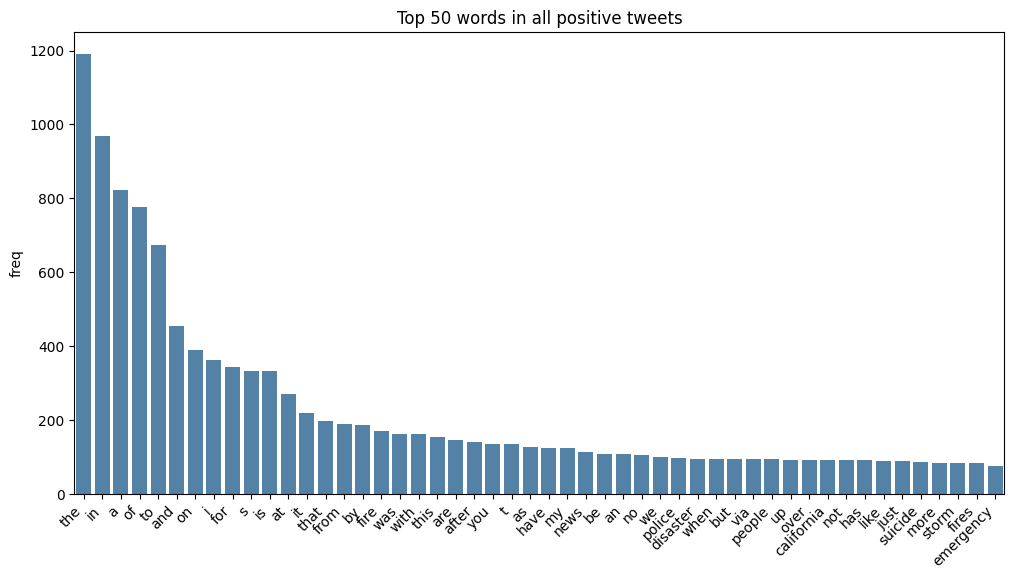

In [24]:
display_top_words(1, 'positive')

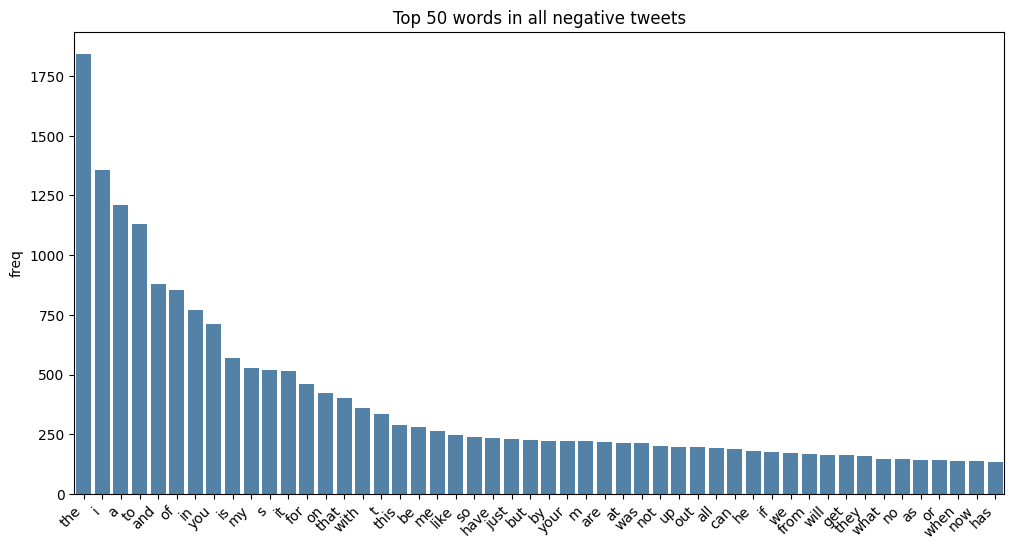

In [25]:
display_top_words(0, 'negative')

Alot of the words seem similar except for 'police', 'disaster', 'emergency' and 'california' showing up for positive examples.

I noticed above that one of the keywords has an escaped character in it (nuclear%20reactor).  It looks like we need to clean the keywords as well.  First replace null keywords with *unk*.

In [26]:
train_no_dupes_df = train_no_dupes_df.copy()
train_no_dupes_df.keyword.fillna('unk', inplace=True)

In [27]:
train_no_dupes_df['clean_keyword'] = train_no_dupes_df.keyword.apply(clean_text)

In [28]:
train_no_dupes_df

,id,keyword,location,text,target,clean_text,clean_keyword
0,1,unk,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,unk
1,4,unk,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,unk
2,5,unk,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,unk
3,6,unk,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...,unk
4,7,unk,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,unk
...,...,...,...,...,...,...,...
7608,10869,unk,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,unk
7609,10870,unk,NaN,@aria_ahrary @TheTawniest The out of control w...,1,aria_ahrary thetawniest the out of control wil...,unk
7610,10871,unk,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m1 5km s of volcano hawaii,unk
7611,10872,unk,NaN,Police investigating after an e-bike collided ...,1,police investigating after an e bike collided ...,unk


The identifier field should be dropped as a feature for training - hopefully it doesn't impact the classification.  Let's also drop location since there are so many null values.

In [29]:
train_no_dupes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6908 entries, 0 to 7612
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             6908 non-null   int64 
 1   keyword        6908 non-null   object
 2   location       4637 non-null   object
 3   text           6908 non-null   object
 4   target         6908 non-null   int64 
 5   clean_text     6908 non-null   object
 6   clean_keyword  6908 non-null   object
dtypes: int64(2), object(5)
memory usage: 689.8+ KB


In [30]:
train_no_dupes_df.drop(['id', 'location'], axis=1, inplace=True)

Let's look at a random sample of the cleaned data to make sure it looks ok.. 

In [31]:
with option_context('display.max_colwidth', 200):
    display(train_no_dupes_df[['clean_keyword', 'clean_text', 'target']].sample(10, random_state=7))

,clean_keyword,clean_text,target
4538,injured,chikislizeth08 you re not injured anymore,0
399,arson,jewish leaders prayed at the hospital where a palestinian family is being treated after arson via huffpostrelig,1
6646,terrorist,you may know me from such roles as terrorist,0
6173,sirens,rappers stop sampling police sirens and start sampling whale song,0
5148,nuclear reactor,snowywolf5 thegreenparty besides would you rather shut down a whole nuclear reactor for maintenance or a wind turbine at a time,1
6945,tsunami,helene_yancey godslove thanku my sister helene for rt of new video the coming apocalyptic us earthquake tsunami,1
4025,forest fire,fire in pisgah national forest grows to acres,1
4777,lightning,when you walk away nothing more to say see the lightning in your eyes see em running for their lives,0
1881,crush,kenny holland crush da vida,0
3969,flooding,themaine is it too soon to start flooding your comment section with come to brazil comments bc i will,0


In [32]:
vocab_ctr = Counter([w for t in train_no_dupes_df.clean_text for w in t.split()])
init_vocab = [v for v, c in vocab_ctr.most_common() if c > 1]
len(init_vocab)

6237

# Model Architecture

RNN models are ideal for sequence classification problems like this.  With their recursive nature, they capture dependencies between items in a sequence that can help in classifying text.

We are going to try a few of the gated RNN variations, however, namely LSTM and GRU.  Even though tweets are short, we still may have problems with vanishing or exploding gradients with vanilla RNNs.

In particular, we use BiLSTMs and BiGRUs.  The unidirectional variants (LSTM and GRU) tend to ignore elements near the end of the end of the sequence. The bi-directional variants mititgate this. 

Let's first prepend to our vocabulary a *pad* token so sequences in a batch all have the same length.  We also add an *unk* token for OOV terms

In [33]:
vocab = ['<pad>', '<unk>'] + init_vocab
word_by_idx = {i: w for i, w in enumerate(vocab)}
idx_by_word = {w: i for i, w in word_by_idx.items()}

Split the training set into a training and development set.

In [34]:
trn_df, dev_df = train_test_split(train_no_dupes_df, test_size=0.1, random_state=42)

In [35]:
len(trn_df), len(dev_df)

(6217, 691)

Create the data loaders for the training and dev datasets.

In [36]:
class TweetDataset(Dataset):
    def __init__(self, df, idx_by_word):
        self.tweets = list(df.clean_text)
        self.targets = list(df.target)
        self.idx_by_word = idx_by_word

    def __len__(self):
        return len(self.tweets)

    def process(self, text):
        return [idx_by_word.get(tok, idx_by_word['<unk>']) for tok in text.split()]
    
    def __getitem__(self, idx):
        tweet_text, target = self.tweets[idx], self.targets[idx]
        return torch.tensor(self.process(tweet_text)), torch.tensor(target, dtype=torch.float)

In [37]:
def collate_fn(examples):
    """
    Create a proper batch, including padding for tweets and targets.
    """
    inputs, targets = zip(*examples)
    inputs = pad_sequence(inputs, batch_first=True)
    targets = torch.stack(list(targets), dim=0)
    return inputs, targets

In [171]:
# Start with a small batch size
batch_size = 16

In [39]:
train_dataset = TweetDataset(trn_df, idx_by_word)
dev_dataset = TweetDataset(dev_df, idx_by_word)

train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              drop_last=True,
                              collate_fn=collate_fn)

dev_dataloader = DataLoader(dev_dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              drop_last=False,
                              collate_fn=collate_fn)

Any deep learning model needs tokens to be a vector representation.  Here, we choose [Glove](https://nlp.stanford.edu/projects/glove/) embeddings, in particular ones trained on corpus of tweets. [Glove](#References) is trained to learn the probability of word co-occurrences in a corpus.   The representation it learns focuses not just on a probability like $P(solid|ice)$, but on the ratio of probabilities, for example $\frac{P(solid|ice)}{P(solid|steam)}$, which are thought to be more informative. 

In [40]:
glove_100 = GloVe(name='twitter.27B', dim=100)

Normalize the glove embeddings and convert them into tensors.

In [128]:
def gen_word_embedding_matrix(dim):
    glove = GloVe(name='twitter.27B', dim=dim)
    glove_mu = glove.vectors.mean()
    glove_sigma = glove.vectors.std()
    
    embedding_sz = glove.vectors[0].shape[0]
    pad_embedding = torch.zeros_like(glove.vectors[0])
    unk_embedding = torch.randn(embedding_sz) * glove_sigma + glove_mu
    word_embeddings = [pad_embedding, unk_embedding]
    for w in init_vocab:
        if w in glove.stoi:
            word_embeddings.append(glove.vectors[glove.stoi[w]])
        else:
            word_embeddings.append(torch.randn(embedding_sz) * glove_sigma + glove_mu)
    word_embeddings = torch.stack(word_embeddings)
    
    return word_embeddings

In [130]:
word_embeddings_100 = gen_word_embedding_matrix(100)

## Baseline BiLSTM

We will start with a BiLSTM.  The class for this defined below.  It's the same class we will use for the BiGRU since the code is so similar.  Only the gate type needs to be specified to switch between the two.

In [150]:
class TweetGatedRNNModel(nn.Module):
    def __init__(self, word_embeddings, dropout, encoding_dim, n_layers, pad_idx, gate_type='lstm'):
        """
        Bidirectional Gated RNN model.  May either be an LSTM or GRU.

        :param word_embeddings word embedding matrix
        :dropout after embedding layer
        :param encoding_dim: The full size of the hidden output of the BiLSTM.  This is the forward and backward
        hidden outputs concatenated - internally we halve it for the hidden state size.
        :param gate_type either 'lstm' or 'gru'
        """
        super(TweetGatedRNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=False, padding_idx=idx_by_word['<pad>'])
        self.dropout = nn.Dropout(dropout)
        if gate_type == 'lstm':
            self.gated_rnn = nn.LSTM(self.embedding.embedding_dim, encoding_dim // 2,
                                     num_layers=n_layers, batch_first=True, bidirectional=True,
                                     dropout=dropout if n_layers > 1 else 0)
        else:
            self.gated_rnn = nn.GRU(self.embedding.embedding_dim, encoding_dim // 2,
                                    num_layers=n_layers, batch_first=True, bidirectional=True,
                                    dropout=dropout if n_layers > 1 else 0)
        self.out_layer = nn.Linear(encoding_dim, 1)
        self.pad_idx = pad_idx
        self.n_layers = n_layers
        self.encoding_dim = encoding_dim
        self.hidden_size = encoding_dim // 2
        self.gate_type = gate_type

    def init_hidden_states(self, batch_size, device):
        """
        Initialise the hidden states the BiLSTM or BiGRU to zeros.
        :param batch_size: int
            The batch size
        :return: Tensor
            The initialised hidden states
        """
        # [(n_layers x # of directions) x batch_size x hidden_size]
        h = torch.zeros(self.n_layers*2, batch_size, self.hidden_size).to(device)
        if self.gate_type == 'lstm':
            # Also need to initialize cell state
            c = torch.zeros(self.n_layers*2, batch_size, self.hidden_size).to(device)
            return h, c
        return h
    
    def forward(self, text, seq_lengths=None):
        embedded_text = self.embedding(text)
        embedded_text = self.dropout(embedded_text)
        
        batch_size = text.size()[0]
        init_hidden_states = self.init_hidden_states(batch_size, text.device)
        
        # Pack padded batch of sequences for RNN module. 
        seq_lengths = (text != self.pad_idx).sum(-1).to(dtype=torch.int64).to("cpu")
        
        # Passing enforce_sorted=False to pack_padded_sequence
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded_text, seq_lengths, batch_first=True,
                                                         enforce_sorted=False)
        packed_encoded_text, _ = self.gated_rnn(packed, init_hidden_states)
        # Unpack so we can use the encoded text, i.e. the output of the RNN
        encoded_text, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_encoded_text, batch_first=True)

        # Extract the first and last hidden encodings and concat.
        first_hidden = encoded_text[:,0,self.encoding_dim:]
        last_hidden = encoded_text[range(len(encoded_text)),seq_lengths - 1,:self.encoding_dim]
        text_rep = torch.cat((first_hidden, last_hidden), 1)
        
        # Run through output layer
        out = self.out_layer(text_rep)
        return out

We also need to define some functions for the training process.

In [173]:
device = "cuda:1"

In [43]:
def validate(model, dev_dl):
    """
    Evaluate the loss on the validation set.
    """
    model.eval()
    n_examples = 0
    dev_loss = 0.
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dev_dl, 0):
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            dev_loss += loss_fn(logits.squeeze(-1), labels)
            n_examples += labels.shape[0]

    dev_loss = dev_loss.item() / n_examples
    
    return dev_loss

In [120]:
def calc_metrics(model, dev_dl):
    """
    Calculate F1, recall and precision.
    """
    model.eval()
    y = []
    yhat = []
    with torch.no_grad():
        for i, data in enumerate(dev_dl, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            logits = model(inputs)
            preds = (torch.sigmoid(logits) > .5).to(torch.int32).squeeze().cpu().tolist()
            yhat.extend(preds)
            y.extend(labels.to(torch.int32).cpu().tolist())

    f1 = f1_score(y, yhat)
    recall = recall_score(y, yhat)
    precision = precision_score(y, yhat)

    return f1, recall, precision

In [45]:
def train_model(model, lr, n_epochs, train_ds, dev_ds, batch_size):
    """
    Train a model.
    """
    model = model.to(device)

    train_dataloader = DataLoader(train_ds,
                              batch_size=batch_size,
                              shuffle=True,
                              drop_last=True,
                              collate_fn=collate_fn)

    dev_dataloader = DataLoader(dev_ds,
                                  batch_size=batch_size,
                                  shuffle=False,
                                  drop_last=False,
                                  collate_fn=collate_fn)

    optimizer = optim.AdamW(params=model.parameters(), lr=lr)
    
    n_steps = 0
    for epoch in range(n_epochs):
        running_loss = 0.0
        n_examples = 0
        model.train()
        for i, (inputs, targets) in enumerate(train_dataloader, 0):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            logits = model(inputs)
            loss = loss_fn(logits.squeeze(-1), targets)
            loss.backward()
            optimizer.step()

            # Print statistics and save losses (train and dev)
            running_loss += loss.item()
            n_examples += len(targets)
            if i != 0 and i % 100 == 0:
                train_loss = running_loss / n_examples
                print(f'step {n_steps}, loss: {train_loss:.3f}')
                running_loss = 0.0
                n_examples = 0
            n_steps += 1

        # Get validation loss and calc metrics
        dev_loss = validate(model, dev_dataloader)
        f1, recall, precision = calc_metrics(model, dev_dataloader)
        print(f'[epoch {epoch + 1}] dev loss: {dev_loss:.3f}, f1={f1:.3f}, recall={recall:.3f} precision={precision:.3f}')

We are not going to vary the loss function - given that this is a binary task let's use binary cross entropy.  This will be used across all models.

In [46]:
loss_fn = nn.BCEWithLogitsLoss()

Let's try a baseline BiLSTM which uses the 100 dim glove embeddings, has 1 layer, a hidden size of 256, a dropout rate of 0.3 and is trained with a batch size of 16.

In [208]:
baseline_bilstm_model = TweetGatedRNNModel(word_embeddings_100, 0.3, 256, 1, idx_by_word['<pad>'])
train_model(baseline_bilstm_model, 0.001, 5, train_dataset, dev_dataset, 16)

step 100, loss: 0.036
step 200, loss: 0.030
step 300, loss: 0.031
[epoch 1] dev loss: 0.029, f1=0.751, recall=0.728 precision=0.776
step 488, loss: 0.027
step 588, loss: 0.026
step 688, loss: 0.027
[epoch 2] dev loss: 0.028, f1=0.755, recall=0.717 precision=0.797
step 876, loss: 0.022
step 976, loss: 0.024
step 1076, loss: 0.023
[epoch 3] dev loss: 0.028, f1=0.745, recall=0.679 precision=0.824
step 1264, loss: 0.019
step 1364, loss: 0.021
step 1464, loss: 0.020
[epoch 4] dev loss: 0.032, f1=0.740, recall=0.697 precision=0.789
step 1652, loss: 0.017
step 1752, loss: 0.017
step 1852, loss: 0.018
[epoch 5] dev loss: 0.033, f1=0.752, recall=0.728 precision=0.779


In [209]:
torch.save(baseline_bilstm_model, 'baseline_bilstm_model.pth')

In [210]:
f1, recall, precision = calc_metrics(baseline_bilstm_model, dev_dataloader)
print(f"Baseline BiLSTM model has an f1={f1:.3f}, recall={recall:.3f} and precision={precision:.3f}")

Baseline BiLSTM model has an f1=0.752, recall=0.728 and precision=0.779


That's not horrible.  Does a baseline BiGRU do any better?

## Baseline BiGRU

In [152]:
baseline_gru_model = TweetGatedRNNModel(word_embeddings, 0.3, 256, 1, idx_by_word['<pad>'], gate_type='gru')
train_model(baseline_gru_model, 0.001, 5, train_dataset, dev_dataset, 16)

step 100, loss: 0.036
step 200, loss: 0.032
step 300, loss: 0.029
[epoch 1] dev loss: 0.029, f1=0.715, recall=0.624 precision=0.838
step 488, loss: 0.026
step 588, loss: 0.026
step 688, loss: 0.026
[epoch 2] dev loss: 0.028, f1=0.738, recall=0.669 precision=0.822
step 876, loss: 0.022
step 976, loss: 0.024
step 1076, loss: 0.022
[epoch 3] dev loss: 0.029, f1=0.750, recall=0.728 precision=0.773
step 1264, loss: 0.019
step 1364, loss: 0.020
step 1464, loss: 0.018
[epoch 4] dev loss: 0.032, f1=0.720, recall=0.652 precision=0.804
step 1652, loss: 0.016
step 1752, loss: 0.015
step 1852, loss: 0.016
[epoch 5] dev loss: 0.032, f1=0.734, recall=0.690 precision=0.784


In [206]:
torch.save(baseline_gru_model, 'baseline_gru_model.pth')

In [156]:
f1, recall, precision = calc_metrics(baseline_gru_model, dev_dataloader)
print(f"Baseline BiGRU model has an f1={f1:.3f}, recall={recall:.3f} and precision={precision:.3f}")

Baseline BiGRU model has an f1=0.734, recall=0.690 and precision=0.784


This performs worse than the BiLSTM.  But perhaps we can do a hyperparameter search on both of these models in the next section to come up with better results.

# Results and Analysis

## Hyperparameter Search

In this section, we will do a hyperparameter search on the BiLSTM and BiGRU models to improve their performance.  To help automate this, we will use [Weights and Biases](https://wandb.ai/site) to conduct a hyperparameter sweep.

In [51]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lyol9217 (codegreen). Use `wandb login --relogin` to force relogin


True

We have to define the hyperparmeters we want to sample and the metric we want to log, in our case F1, in a 'sweep' config.

In [168]:
sweep_config = {
    'method': 'random',
    'name': 'sweep',
    'metric': {
        'goal': 'maximize', 
        'name': 'f1'
        },
    'parameters': {
        'batch_size': {'values': [16, 32, 64]},
        'embedding_dim': {'values': [50, 100, 200]},
        'encoding_dim': {'values': [64, 128, 256, 512]},
        'n_layers': {'values': [1, 2]},
        'dropout': {'values': [0.2, 0.3, 0.4, 0.5]},
        'optimizer': {'values': ['adam', 'adamw']},
        'epochs': {'values': [5, 10, 15, 20]},
        'lr': {'max': 0.001, 'min': 0.00001}
     }
}

We also need to load the glove embedding dimension sizes we want to test.

In [131]:
word_embeddings_50 = gen_word_embedding_matrix(50)
word_embeddings_100 = gen_word_embedding_matrix(100)
word_embeddings_200 = gen_word_embedding_matrix(200)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1193513/1193514 [00:15<00:00, 76169.36it/s]


And define some functions for training which will be called by Weights and Biases.

In [136]:
def build_dataset(batch_size):
    """
    Create a train dataset loader with the specified batch size
    """
    loader = DataLoader(train_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        drop_last=True,
                        collate_fn=collate_fn)

    return loader

In [164]:
def build_model(embedding_dim, encoding_dim, n_layers, dropout, gate_type='lstm'):
    """
    Create a model with various hyperparameters such as number of layers in network, the gate type, etc.
    """
    if embedding_dim == 50:
        word_embeddings = word_embeddings_50
    elif embedding_dim == 200:
        word_embeddings = word_embeddings_200
    else:
        word_embeddings = word_embeddings_100

    model = TweetGatedRNNModel(word_embeddings, dropout, encoding_dim, n_layers, idx_by_word['<pad>'], gate_type=gate_type)
    return model.to(device)

In [138]:
def build_optimizer(model, optimizer, learning_rate):
    """
    Create an Adam-based or SGD optimizer with the specified learning rate.
    """
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate)
    elif optimizer == "adamw":
        optimizer = optim.AdamW(params=model.parameters(), lr=learning_rate)
    return optimizer

In [139]:
def train_epoch(model, train_dl, optimizer):
    """
    Train a model for one epoch and return the average training loss.
    """
    running_loss = 0
    model.train()
    for i, (inputs, targets) in enumerate(train_dl, 0):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        # forward + backward + optimize
        logits = model(inputs)
        loss = loss_fn(logits.squeeze(-1), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(train_dl)

In [135]:
def train(config=None):
    """
    Initialize and train a new hyperperameter configuration
    """
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Conatroller
        config = wandb.config

        loader = build_dataset(config.batch_size)
        model = build_model(config.embedding_dim, config.encoding_dim, config.n_layers, config.dropout, gate_type='gru')
        optimizer = build_optimizer(model, config.optimizer, config.lr)

        for epoch in range(config.epochs):
            avg_loss = train_epoch(model, loader, optimizer)
            wandb.log({"loss": avg_loss, "epoch": epoch})
            f1, recall, precision = calc_metrics(model, dev_dataloader)
            wandb.log({"f1": f1, "epoch": epoch})

In [140]:
sweep_id = wandb.sweep(sweep_config, project="week-sweeps-lstm-v2")

Create sweep with ID: nupxxwil
Sweep URL: https://wandb.ai/codegreen/week-sweeps-lstm-v2/sweeps/nupxxwil


In [141]:
wandb.agent(sweep_id, train, count=30)

wandb: Agent Starting Run: ab08pcik with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 100
wandb: 	encoding_dim: 512
wandb: 	epochs: 10
wandb: 	lr: 0.00026043940466377125
wandb: 	n_bilstm_layers: 2
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
f1,▂▁▇▆▃▅▅▇██
loss,█▅▄▄▃▃▂▂▂▁
epoch,9
f1,0.7532
loss,0.32649


wandb: Agent Starting Run: 1qoy90nj with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 128
wandb: 	epochs: 5
wandb: 	lr: 0.00017508361319171654
wandb: 	n_bilstm_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▃▃▅▅▆▆██
f1,▁████
loss,█▄▃▂▁
epoch,4
f1,0.7518
loss,0.44985


wandb: Agent Starting Run: xznggwyz with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 128
wandb: 	epochs: 10
wandb: 	lr: 0.00026418866074849606
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
f1,▁▇████████
loss,█▅▃▃▂▂▂▂▁▁
epoch,9
f1,0.74088
loss,0.4302


wandb: Agent Starting Run: usv4g2k7 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	embedding_dim: 100
wandb: 	encoding_dim: 64
wandb: 	epochs: 20
wandb: 	lr: 0.0009097056028507256
wandb: 	n_bilstm_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
f1,▁▄▄▆█▆▅█▅▆▅▄▄▅▄▃▂▃▃▂
loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
epoch,19
f1,0.71945
loss,0.11302


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zjqbk3j4 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 256
wandb: 	epochs: 20
wandb: 	lr: 0.0008624508963852167
wandb: 	n_bilstm_layers: 2
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
f1,▆▇▁▆▆▅█▅▇██▄█▇▅▇▆▆▆▆
loss,█▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▁▁▁▁
epoch,19
f1,0.73684
loss,0.18348


wandb: Agent Starting Run: mw14zb0y with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 512
wandb: 	epochs: 20
wandb: 	lr: 0.0002339646624374691
wandb: 	n_bilstm_layers: 2
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
f1,▁▆▅▆▇▆▆▆▆▆██▇▇▇▇▇▇▇█
loss,█▅▅▄▄▄▄▃▃▃▃▃▂▂▂▁▂▁▁▁
epoch,19
f1,0.75786
loss,0.3327


wandb: Agent Starting Run: iluymgn2 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.4
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 64
wandb: 	epochs: 15
wandb: 	lr: 0.00097565188158093
wandb: 	n_bilstm_layers: 2
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
f1,▁▅▇█▆▆▇▇▇▇█▇▇▅▆
loss,█▆▆▅▅▄▄▃▃▂▂▂▁▁▁
epoch,14
f1,0.75427
loss,0.17647


wandb: Agent Starting Run: jlqp97es with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 512
wandb: 	epochs: 15
wandb: 	lr: 0.0005611204101287223
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
f1,▅▁▃▅▅▆▅█▅█▆██▄▅
loss,█▆▅▅▄▄▄▃▃▂▂▂▁▁▁
epoch,14
f1,0.72973
loss,0.31935


wandb: Agent Starting Run: adit6qa1 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 512
wandb: 	epochs: 10
wandb: 	lr: 0.0004240103070681588
wandb: 	n_bilstm_layers: 2
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
f1,▁▃█▂▆▅▂▄▁▅
loss,█▆▅▄▄▃▃▂▁▁
epoch,9
f1,0.746
loss,0.26907


wandb: Agent Starting Run: nk61mhz6 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 128
wandb: 	epochs: 5
wandb: 	lr: 0.000710331028329271
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▃▃▅▅▆▆██
f1,▁▄███
loss,█▄▃▂▁
epoch,4
f1,0.73783
loss,0.39724


wandb: Agent Starting Run: 2wexygz0 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 100
wandb: 	encoding_dim: 128
wandb: 	epochs: 15
wandb: 	lr: 0.0007054647698991512
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
f1,▁▇▆▆█▆▄▃▄▃▄▃▃▂▁
loss,█▇▆▅▄▄▃▃▂▂▂▂▁▁▁
epoch,14
f1,0.68893
loss,0.06021


wandb: Agent Starting Run: pjahc6s8 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 100
wandb: 	encoding_dim: 128
wandb: 	epochs: 5
wandb: 	lr: 0.0003820428954545139
wandb: 	n_bilstm_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▃▃▅▅▆▆██
f1,▁▂▄▃█
loss,█▄▃▂▁
epoch,4
f1,0.75046
loss,0.38698


wandb: Agent Starting Run: hklmcln1 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 100
wandb: 	encoding_dim: 128
wandb: 	epochs: 5
wandb: 	lr: 0.0007331638637387875
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▃▃▅▅▆▆██
f1,█▁▂▆█
loss,█▄▃▂▁
epoch,4
f1,0.75694
loss,0.38156


wandb: Agent Starting Run: nn8ofbl2 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 512
wandb: 	epochs: 15
wandb: 	lr: 0.000645532503765884
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
f1,▂▁▂▁▇▆▇▆▇█▃▇▅▅▆
loss,█▆▆▅▅▄▄▃▃▃▂▂▂▁▁
epoch,14
f1,0.74153
loss,0.22402


wandb: Agent Starting Run: mpzorr5w with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 128
wandb: 	epochs: 10
wandb: 	lr: 0.000844654400458782
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
f1,█▇▃▂▆▁▇▃▃▁
loss,█▆▅▄▄▃▂▂▁▁
epoch,9
f1,0.71351
loss,0.14895


wandb: Agent Starting Run: zzetp9k5 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 128
wandb: 	epochs: 10
wandb: 	lr: 0.0003872359051061439
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
f1,▁▆▅▆▅▇▇▇█▆
loss,█▅▄▃▃▂▂▂▁▁
epoch,9
f1,0.72266
loss,0.3724


wandb: Agent Starting Run: r0gxjdyy with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	embedding_dim: 100
wandb: 	encoding_dim: 256
wandb: 	epochs: 10
wandb: 	lr: 0.00017490612684415737
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
f1,▁▁▃▆▆█▆▃▆█
loss,█▄▄▃▂▂▂▂▁▁
epoch,9
f1,0.75812
loss,0.38538


wandb: Agent Starting Run: gr3ara2y with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 64
wandb: 	epochs: 20
wandb: 	lr: 0.0003473932791375106
wandb: 	n_bilstm_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
f1,▁▅▇█▅▆▄▇▄▄▅▂▃▃▂▄▂▂▁▃
loss,█▆▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
epoch,19
f1,0.73333
loss,0.09316


wandb: Agent Starting Run: 9e0ipgx0 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 512
wandb: 	epochs: 15
wandb: 	lr: 0.0003690386889120365
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
f1,▇▆▆█▆▄▄▅▃▄▃▁▄▃▄
loss,█▇▆▅▅▄▄▃▃▂▂▂▁▁▁
epoch,14
f1,0.71875
loss,0.09178


wandb: Agent Starting Run: nlvq0nx6 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 512
wandb: 	epochs: 20
wandb: 	lr: 0.000978261958729451
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
f1,▂▇▆██▅▆▇▆▅▆▆▅▄▃▄▃▁▂▁
loss,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch,19
f1,0.6991
loss,0.06841


wandb: Agent Starting Run: 40uhjpbo with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 100
wandb: 	encoding_dim: 64
wandb: 	epochs: 20
wandb: 	lr: 0.00036186492443204154
wandb: 	n_bilstm_layers: 2
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
f1,▁▄▅▆▇▇▇█▇██▇▇▆▇▇▆▇▇▆
loss,█▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch,19
f1,0.75315
loss,0.28745


wandb: Agent Starting Run: gic0auff with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 64
wandb: 	epochs: 15
wandb: 	lr: 0.00010010383482996458
wandb: 	n_bilstm_layers: 2
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
f1,▁▂▆████████████
loss,█▇▆▅▄▃▃▃▂▂▂▁▁▁▁
epoch,14
f1,0.76
loss,0.36329


wandb: Agent Starting Run: pvuy9u4d with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 64
wandb: 	epochs: 10
wandb: 	lr: 3.3731209630307416e-05
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
f1,▄▃▂▁▁▂▂▃▆█
loss,██▇▇▆▆▅▄▃▁
epoch,9
f1,0.54419
loss,0.60575


wandb: Agent Starting Run: chbms6lb with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 64
wandb: 	epochs: 10
wandb: 	lr: 0.0003942458793024592
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
f1,▁▅█▇▅▆█▄▆▄
loss,█▅▄▄▃▃▂▂▁▁
epoch,9
f1,0.73427
loss,0.23556


wandb: Agent Starting Run: wxveqchg with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 128
wandb: 	epochs: 15
wandb: 	lr: 0.0003861206271905637
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
f1,▄▄▅█▇▅▄▆▃▂▃▃▁▁▂
loss,█▆▅▅▄▄▃▃▃▂▂▂▂▁▁
epoch,14
f1,0.74126
loss,0.18747


wandb: Agent Starting Run: in2qmles with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 128
wandb: 	epochs: 10
wandb: 	lr: 0.0006745235550177274
wandb: 	n_bilstm_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
f1,▄▁▄▆▃▁█▇▇▇
loss,█▅▄▄▃▃▂▂▁▁
epoch,9
f1,0.75368
loss,0.32707


wandb: Agent Starting Run: bwu8dlqx with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 64
wandb: 	epochs: 20
wandb: 	lr: 0.0009466955562260648
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
f1,▁▇▇█▇▇▇▇▇█▄▆▆▆▆▆▅▅▅▄
loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,19
f1,0.72143
loss,0.07536


wandb: Agent Starting Run: kdqtrxvq with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 512
wandb: 	epochs: 20
wandb: 	lr: 0.0007221829967479057
wandb: 	n_bilstm_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
f1,▄█▇▅▆▇█▇▇▄▃▅▅▄▃▁▄▅▄▇
loss,█▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁
epoch,19
f1,0.73826
loss,0.09399


wandb: Agent Starting Run: wet3uuq0 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 512
wandb: 	epochs: 15
wandb: 	lr: 0.0005887999822170559
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
f1,▆▁▂▇▅███▅▇██▆█▆
loss,█▆▆▅▅▄▄▃▃▃▂▂▁▁▁
epoch,14
f1,0.74019
loss,0.27901


wandb: Agent Starting Run: 3x385b9s with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 512
wandb: 	epochs: 10
wandb: 	lr: 0.0005990374666459011
wandb: 	n_bilstm_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
f1,▁▄▆▇▆█▇█▆▇
loss,█▆▅▄▄▃▃▂▂▁
epoch,9
f1,0.75182
loss,0.35444


Several charts are generated as shown below.

In [193]:
ipyplot.plot_images(['img/bilstm_wandb_f1_chart.png', 'img/bilstm_wandb_imp_hyperparams.png'], max_images=2, img_width=600);

The one on the left shows us all of the runs that were generated and their resulting score.  We can see that there were a number of hyperparameter configurations that produced an F1 score of about 0.76 on the dev set.  The figure on the right shows which hyperparameters mattered the most in improving F1, including whether the influence was positive or negative.  In our case, the learning rate had the biggest impact, with a slightly positive correlation.  Not setting the dropout too high and having multiple layers helped.

Specific hyperparmeter configurations can be selected in the parallel coordinate plot as shown below.  The top performing one is highlighted.

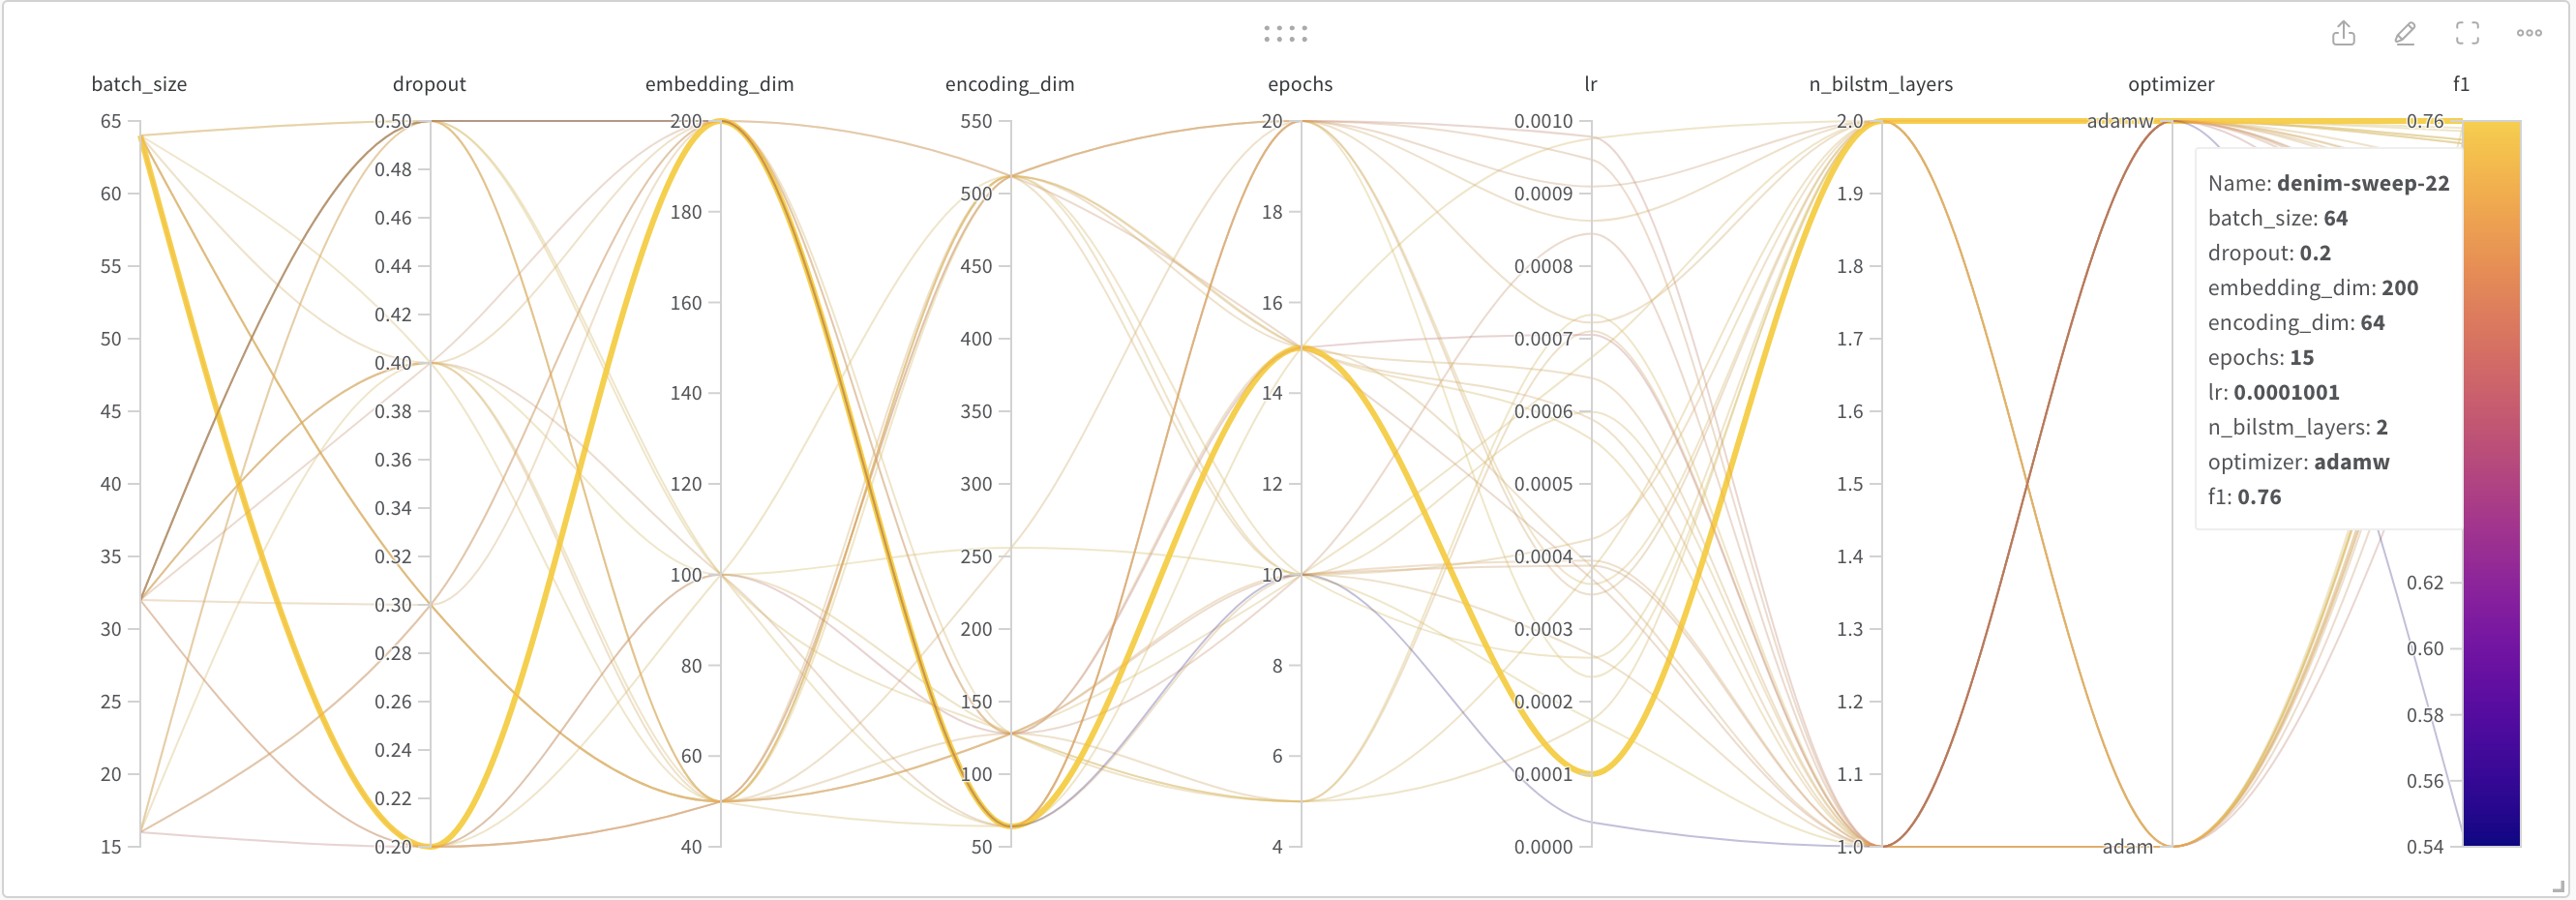

In [199]:
Image(filename = "img/bilstm_parallel_coords_plot.png", width=1400, height=800)

Let's select the best model's parameters and train a model using those settings.

In [161]:
best_lstm_model = TweetGatedRNNModel(word_embeddings_200, 0.2, 64, 2, idx_by_word['<pad>'])
train_model(best_lstm_model, 0.0001, 15, train_dataset, dev_dataset, 64)

/home/lynn/anaconda3/envs/msds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[epoch 1] dev loss: 0.011, f1=0.000, recall=0.000 precision=0.000
[epoch 2] dev loss: 0.010, f1=0.085, recall=0.045 precision=0.867
[epoch 3] dev loss: 0.009, f1=0.671, recall=0.569 precision=0.817
[epoch 4] dev loss: 0.008, f1=0.725, recall=0.676 precision=0.781
[epoch 5] dev loss: 0.008, f1=0.738, recall=0.714 precision=0.764
[epoch 6] dev loss: 0.007, f1=0.750, recall=0.724 precision=0.778
[epoch 7] dev loss: 0.007, f1=0.735, recall=0.659 precision=0.830
[epoch 8] dev loss: 0.007, f1=0.757, recall=0.741 precision=0.773
[epoch 9] dev loss: 0.007, f1=0.762, recall=0.724 precision=0.805
[epoch 10] dev loss: 0.007, f1=0.760, recall=0.721 precision=0.804
[epoch 11] dev loss: 0.007, f1=0.760, recall=0.728 precision=0.796
[epoch 12] dev loss: 0.007, f1=0.759, recall=0.728 precision=0.793
[epoch 13] dev loss: 0.007, f1=0.763, recall=0.710 precision=0.824
[epoch 14] dev loss: 0.007, f1=0.761, recall=0.731 precision=0.794
[epoch 15] dev loss: 0.007, f1=0.762, recall=0.717 precision=0.812


In [162]:
torch.save(best_lstm_model, 'best_lstm_model.pth')

In [200]:
f1, recall, precision = calc_metrics(best_lstm_model, dev_dataloader)
print(f"Best BiLSTM model has an f1={f1:.3f}, recall={recall:.3f} and precision={precision:.3f}")

Best BiLSTM model has an f1=0.762, recall=0.717 and precision=0.812


This is a little better than the baseline which had an F1 of 0.752.

Let's do a hyperameter search for the BiGRU as well.

In [169]:
sweep_id = wandb.sweep(sweep_config, project="week-sweeps-gru-v2")

Create sweep with ID: 9ykjjgcc
Sweep URL: https://wandb.ai/codegreen/week-sweeps-gru-v2/sweeps/9ykjjgcc


In [170]:
wandb.agent(sweep_id, train, count=20)

wandb: Agent Starting Run: lkz15694 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 512
wandb: 	epochs: 5
wandb: 	lr: 0.00035649027397496993
wandb: 	n_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▃▃▅▅▆▆██
f1,▁▇▄▄█
loss,█▄▃▂▁
epoch,4
f1,0.75136
loss,0.34208


wandb: Agent Starting Run: bsjid74i with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.4
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 64
wandb: 	epochs: 10
wandb: 	lr: 0.0004760264543226573
wandb: 	n_layers: 2
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
f1,▅▃▁█▇▇▄▆▅▅
loss,█▆▅▄▄▃▂▂▁▁
epoch,9
f1,0.74658
loss,0.20904


wandb: Agent Starting Run: 0aa0i5vt with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.4
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 128
wandb: 	epochs: 10
wandb: 	lr: 0.0006010157904191075
wandb: 	n_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
f1,▂▁▇▆▆▆█▆▇▇
loss,█▆▅▄▃▃▂▂▁▁
epoch,9
f1,0.7585
loss,0.30551


wandb: Agent Starting Run: e8tb43ig with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 128
wandb: 	epochs: 10
wandb: 	lr: 6.205510991717907e-05
wandb: 	n_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
f1,▁▆▇▇██████
loss,█▆▄▂▂▂▁▁▁▁
epoch,9
f1,0.74866
loss,0.48078


wandb: Agent Starting Run: lg9bg1i8 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 512
wandb: 	epochs: 20
wandb: 	lr: 0.000530213317182283
wandb: 	n_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
f1,▅▅▄▆▅▆▅█▇▆▅▅▃▅▁▅▃▅▃▁
loss,█▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁
epoch,19
f1,0.71875
loss,0.16037


wandb: Agent Starting Run: tgz8px33 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 64
wandb: 	epochs: 20
wandb: 	lr: 0.0004905602710317903
wandb: 	n_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
f1,▁▃▂▅▅█▇▅▃▇▆▆█▅▅▇▄▃▃▃
loss,█▆▆▅▅▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁
epoch,19
f1,0.73298
loss,0.1348


wandb: Agent Starting Run: j5gvxg06 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 64
wandb: 	epochs: 15
wandb: 	lr: 0.0003407335321364465
wandb: 	n_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
f1,▁▅▇▇▇▇████▇████
loss,█▇▅▄▃▃▃▃▂▂▂▂▁▁▁
epoch,14
f1,0.76243
loss,0.33112


wandb: Agent Starting Run: 2wkwfhxa with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 64
wandb: 	epochs: 15
wandb: 	lr: 0.0003806801518798954
wandb: 	n_layers: 2
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
f1,▇▂███▇█▆▇▆▄▄▁▁▄
loss,█▆▅▅▄▄▃▃▂▂▂▁▁▁▁
epoch,14
f1,0.726
loss,0.07719


wandb: Agent Starting Run: h0iajpsc with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 512
wandb: 	epochs: 15
wandb: 	lr: 0.0005315939904464317
wandb: 	n_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
f1,▃▂▁▅▄▅▅▇█▄▅▅█▅▅
loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▁
epoch,14
f1,0.7325
loss,0.23333


wandb: Agent Starting Run: elp55j00 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 512
wandb: 	epochs: 20
wandb: 	lr: 9.647250303952148e-05
wandb: 	n_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
f1,▁█▄▃█▅▇▆▇▆▅▅▅▄▅▅▄▃▅▃
loss,█▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁
epoch,19
f1,0.72593
loss,0.25768


wandb: Agent Starting Run: ly9d22my with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 512
wandb: 	epochs: 10
wandb: 	lr: 0.0003831368859776517
wandb: 	n_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
f1,▁▆▄▅▇▇▃█▇▆
loss,█▅▅▄▃▃▂▂▂▁
epoch,9
f1,0.72908
loss,0.37039


wandb: Agent Starting Run: w4tbe4s3 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 100
wandb: 	encoding_dim: 256
wandb: 	epochs: 20
wandb: 	lr: 0.0009095313794258164
wandb: 	n_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
f1,▆█▇▇▆▅▂▃▆▃▂▂▂▂▂▂▁▂▃▂
loss,█▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,19
f1,0.69831
loss,0.03226


wandb: Agent Starting Run: 1t5gnhwg with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 256
wandb: 	epochs: 5
wandb: 	lr: 0.0007282204778348492
wandb: 	n_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▃▃▅▅▆▆██
f1,▇▂█▃▁
loss,█▆▄▂▁
epoch,4
f1,0.72495
loss,0.19428


wandb: Agent Starting Run: l336wgr6 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 100
wandb: 	encoding_dim: 512
wandb: 	epochs: 20
wandb: 	lr: 0.0006222345763662964
wandb: 	n_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
f1,▄█▅▆▆▄▁▃▂▁▃▃▃▃▂▃▁▁▁▂
loss,█▇▆▅▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch,19
f1,0.69534
loss,0.03699


wandb: Agent Starting Run: begwwor3 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 128
wandb: 	epochs: 10
wandb: 	lr: 0.0007232889218245245
wandb: 	n_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
f1,▁▆▅▇▇▆▇▆█▅
loss,█▅▄▃▃▃▂▂▁▁
epoch,9
f1,0.71825
loss,0.36785


wandb: Agent Starting Run: e1c2jlcl with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 256
wandb: 	epochs: 10
wandb: 	lr: 0.00018581239165875376
wandb: 	n_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
f1,▁▆▇▇▇█▇█▇▆
loss,█▅▃▃▂▂▂▂▁▁
epoch,9
f1,0.73077
loss,0.37804


wandb: Agent Starting Run: r7wjher2 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 200
wandb: 	encoding_dim: 128
wandb: 	epochs: 15
wandb: 	lr: 0.00016238849430923438
wandb: 	n_layers: 2
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
f1,▁▅▆▅▇██▅▇▇▅▅▄▄▄
loss,█▆▅▄▄▄▃▃▃▂▂▂▁▁▁
epoch,14
f1,0.73369
loss,0.22975


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u8puy7eb with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 128
wandb: 	epochs: 5
wandb: 	lr: 0.00033383008321843157
wandb: 	n_layers: 1
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▃▃▅▅▆▆██
f1,▁▂▇█▅
loss,█▄▂▂▁
epoch,4
f1,0.73823
loss,0.40568


wandb: Agent Starting Run: 7niofjw9 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 100
wandb: 	encoding_dim: 512
wandb: 	epochs: 20
wandb: 	lr: 0.000983637986589706
wandb: 	n_layers: 1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
f1,▅▄█▆▇▆▅▆▆▅▅▅▄▇▇▃▃▁▄▂
loss,█▇▆▆▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch,19
f1,0.70934
loss,0.08303


wandb: Agent Starting Run: uih8mac6 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	embedding_dim: 50
wandb: 	encoding_dim: 256
wandb: 	epochs: 5
wandb: 	lr: 0.0008689853909944586
wandb: 	n_layers: 2
wandb: 	optimizer: adamw
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch,▁▁▃▃▅▅▆▆██
f1,█▆▁█▃
loss,█▅▄▂▁
epoch,4
f1,0.73501
loss,0.38265


The charts generate for this are shown below.

In [201]:
ipyplot.plot_images(['img/bigru_wandb_f1_chart.png', 'img/bigru_wandb_imp_hyperparams.png'], max_images=2, img_width=600);

We have far fewer configurations leading to an F1 score of around 0.76 than we did with BiLSTM.  Also, training for longer seemed to negatively impact peformance along with increasing the size of the hidden (encoding) dimensions.

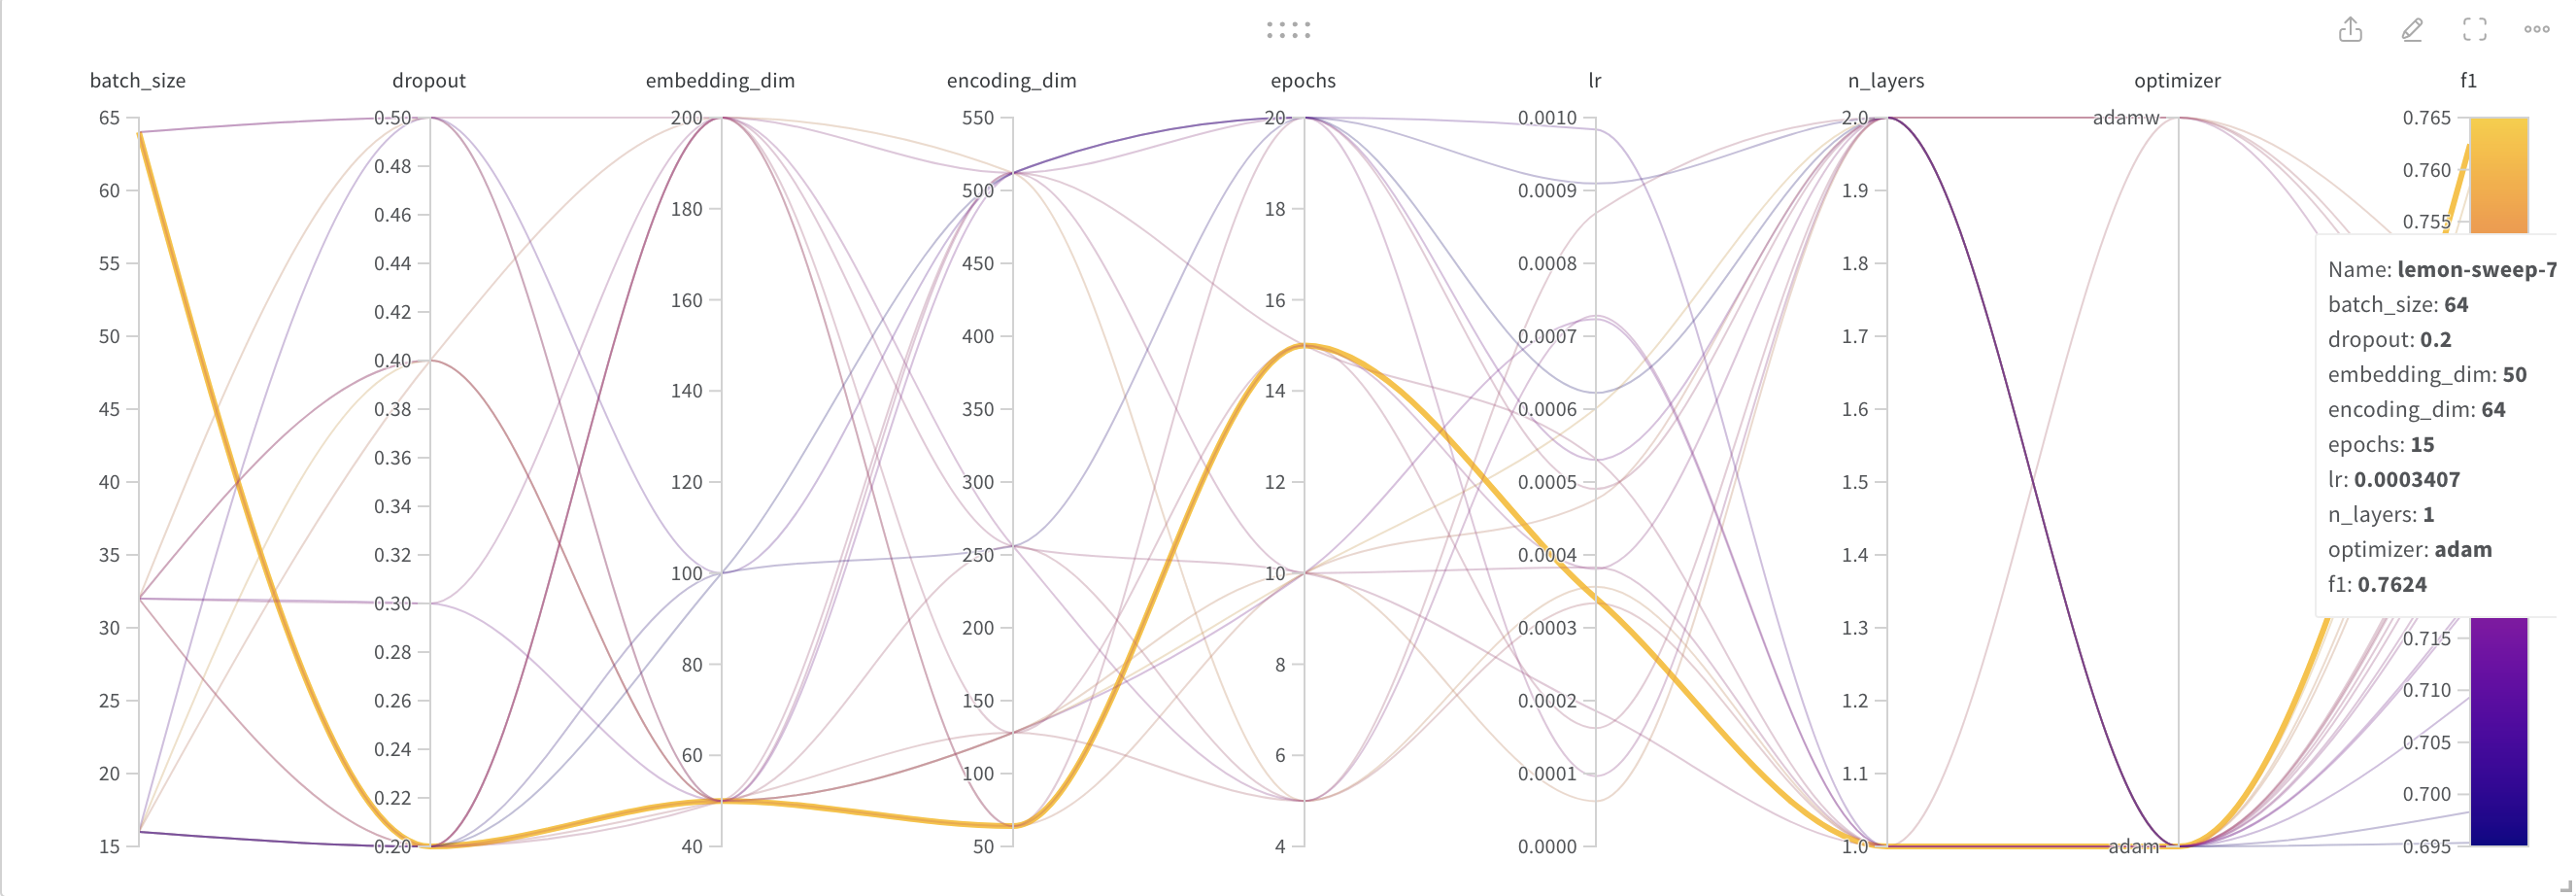

In [202]:
Image(filename = "img/bigru_parallel_coords_plot.png", width=1400, height=800)

Let's train a BiGRU using the best hyperparameter configuration.

In [219]:
best_gru_model = TweetGatedRNNModel(word_embeddings_50, 0.2, 64, 1, idx_by_word['<pad>'], 'gru')
train_model(best_gru_model, 0.0003, 15, train_dataset, dev_dataset, 64)

[epoch 1] dev loss: 0.010, f1=0.420, recall=0.290 precision=0.764
[epoch 2] dev loss: 0.008, f1=0.664, recall=0.607 precision=0.733
[epoch 3] dev loss: 0.008, f1=0.740, recall=0.772 precision=0.711
[epoch 4] dev loss: 0.008, f1=0.734, recall=0.703 precision=0.767
[epoch 5] dev loss: 0.007, f1=0.735, recall=0.690 precision=0.787
[epoch 6] dev loss: 0.007, f1=0.756, recall=0.738 precision=0.775
[epoch 7] dev loss: 0.007, f1=0.748, recall=0.721 precision=0.777
[epoch 8] dev loss: 0.007, f1=0.758, recall=0.728 precision=0.790
[epoch 9] dev loss: 0.007, f1=0.762, recall=0.741 precision=0.785
[epoch 10] dev loss: 0.007, f1=0.755, recall=0.721 precision=0.792
[epoch 11] dev loss: 0.007, f1=0.757, recall=0.734 precision=0.780
[epoch 12] dev loss: 0.007, f1=0.754, recall=0.724 precision=0.787
[epoch 13] dev loss: 0.007, f1=0.762, recall=0.741 precision=0.785
[epoch 14] dev loss: 0.007, f1=0.761, recall=0.734 precision=0.789
[epoch 15] dev loss: 0.007, f1=0.766, recall=0.738 precision=0.796


In [220]:
torch.save(best_gru_model, 'best_gru_model.pth')

In [221]:
f1, recall, precision = calc_metrics(best_gru_model, dev_dataloader)
print(f"Best BiGRU model has an f1={f1:.3f}, recall={recall:.3f} and precision={precision:.3f}")

Best BiGRU model has an f1=0.766, recall=0.738 and precision=0.796


This is a slightly better score than the BiLSTM.

## Kaggle Submission

Let's run these models on the test set and submit the results to Kaggle.

Retrain all of our 2 best models with the full data set.

In [217]:
full_train_dataset = TweetDataset(train_df, idx_by_word)

In [224]:
kaggle_bilstm_model = TweetGatedRNNModel(word_embeddings_200, 0.2, 64, 2, idx_by_word['<pad>'])
train_model(kaggle_bilstm_model, 0.0001, 15, full_train_dataset, dev_dataset, 64)
torch.save(kaggle_bilstm_model, 'kaggle_bilstm_model.pth')

step 100, loss: 0.011


/home/lynn/anaconda3/envs/msds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[epoch 1] dev loss: 0.011, f1=0.000, recall=0.000 precision=0.000
step 218, loss: 0.010
[epoch 2] dev loss: 0.009, f1=0.591, recall=0.459 precision=0.831
step 336, loss: 0.009
[epoch 3] dev loss: 0.008, f1=0.733, recall=0.714 precision=0.753
step 454, loss: 0.008
[epoch 4] dev loss: 0.008, f1=0.709, recall=0.648 precision=0.783
step 572, loss: 0.007
[epoch 5] dev loss: 0.007, f1=0.760, recall=0.728 precision=0.796
step 690, loss: 0.007
[epoch 6] dev loss: 0.007, f1=0.772, recall=0.741 precision=0.805
step 808, loss: 0.006
[epoch 7] dev loss: 0.007, f1=0.785, recall=0.741 precision=0.833
step 926, loss: 0.006
[epoch 8] dev loss: 0.006, f1=0.794, recall=0.776 precision=0.812
step 1044, loss: 0.006
[epoch 9] dev loss: 0.006, f1=0.804, recall=0.793 precision=0.816
step 1162, loss: 0.006
[epoch 10] dev loss: 0.006, f1=0.804, recall=0.786 precision=0.823
step 1280, loss: 0.006
[epoch 11] dev loss: 0.006, f1=0.804, recall=0.755 precision=0.859
step 1398, loss: 0.006
[epoch 12] dev loss: 0.006

In [225]:
kaggle_bigru_model = TweetGatedRNNModel(word_embeddings_50, 0.2, 64, 1, idx_by_word['<pad>'], 'gru')
train_model(kaggle_bigru_model, 0.0003, 15, full_train_dataset, dev_dataset, 64)
torch.save(kaggle_bigru_model, 'kaggle_bigru_model.pth')

step 100, loss: 0.010
[epoch 1] dev loss: 0.010, f1=0.481, recall=0.362 precision=0.714
step 218, loss: 0.009
[epoch 2] dev loss: 0.008, f1=0.664, recall=0.593 precision=0.754
step 336, loss: 0.008
[epoch 3] dev loss: 0.008, f1=0.734, recall=0.676 precision=0.803
step 454, loss: 0.007
[epoch 4] dev loss: 0.007, f1=0.765, recall=0.752 precision=0.779
step 572, loss: 0.007
[epoch 5] dev loss: 0.007, f1=0.752, recall=0.679 precision=0.842
step 690, loss: 0.007
[epoch 6] dev loss: 0.007, f1=0.761, recall=0.697 precision=0.838
step 808, loss: 0.006
[epoch 7] dev loss: 0.006, f1=0.779, recall=0.724 precision=0.843
step 926, loss: 0.006
[epoch 8] dev loss: 0.006, f1=0.783, recall=0.728 precision=0.847
step 1044, loss: 0.006
[epoch 9] dev loss: 0.006, f1=0.797, recall=0.759 precision=0.840
step 1162, loss: 0.006
[epoch 10] dev loss: 0.006, f1=0.799, recall=0.755 precision=0.849
step 1280, loss: 0.006
[epoch 11] dev loss: 0.006, f1=0.798, recall=0.728 precision=0.883
step 1398, loss: 0.006
[epo

Load and prepare the test dataset.

In [211]:
test_df = pd.read_csv('twitter_disaster/test.csv')
len(test_df)

3263

In [212]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [229]:
test_ids = list(test_df.id)

Clean the text data as we did before.

In [213]:
test_df['clean_text'] = test_df.text.apply(clean_text)

Add a target column initialized with all zeros.

In [214]:
test_df['target'] = 0

In [226]:
test_dataset = TweetDataset(test_df, idx_by_word)
test_dataloader = DataLoader(test_dataset,
                             batch_size=64,
                             shuffle=False,
                             drop_last=False,
                             collate_fn=collate_fn)

We will generate predictions using the models we generated above and update a copy of the test dataframe.

In [227]:
def predict(model, test_dl):
    """
    Generate predictions on the test dataset.
    """
    model.eval()
    yhat = []
    with torch.no_grad():
        for i, data in enumerate(test_dl, 0):
            inputs, _ = data
            inputs = inputs.to(device)
        
            logits = model(inputs)
            preds = (torch.sigmoid(logits) > .5).to(torch.int32).squeeze().cpu().tolist()
            yhat.extend(preds)

    return yhat

In [236]:
kaggle_bilstm_model = torch.load('kaggle_bilstm_model.pth')
kaggle_bilstm_model_preds = predict(kaggle_bilstm_model, test_dataloader)
kaggle_bilstm_model_preds_df = pd.DataFrame(data={'id': test_ids, 'target': kaggle_bilstm_model_preds})
kaggle_bilstm_model_preds_df.to_csv('kaggle_bilstm_model_submission.csv', index=False)

In [237]:
kaggle_bigru_model = torch.load('kaggle_bigru_model.pth')
kaggle_bigru_model_preds = predict(kaggle_bigru_model, test_dataloader)
kaggle_bigru_model_preds_df = pd.DataFrame(data={'id': test_ids, 'target': kaggle_bigru_model_preds})
kaggle_bigru_model_preds_df.to_csv('kaggle_bigru_model_submission.csv', index=False)

The test results from Kaggle are shown in the table below.

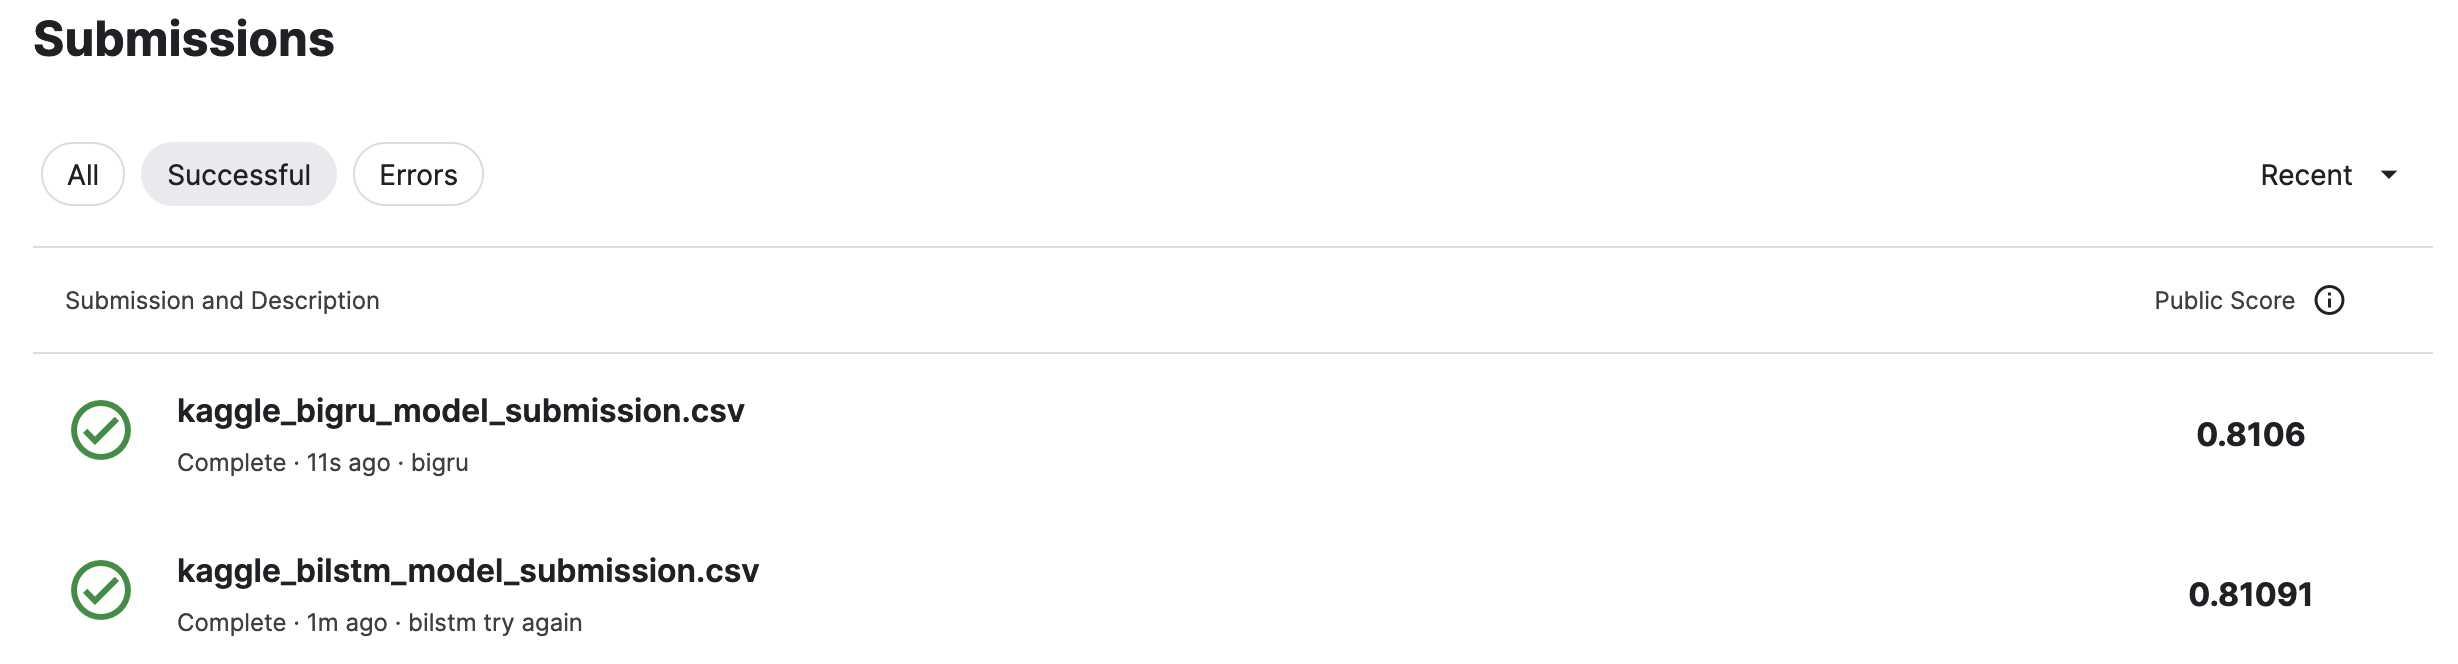

In [239]:
Image(filename = "img/kaggle_table.png", width=800, height=600)

Truthfully, either model seems to perform OK, but nowhere near the top of the leaderboard.

# Conclusion

For this project, we trained a BiLSTM and a BiGRU to classify tweets as relating to a natural disaster or not.  It would have been nice to use the keywords but for time's sake we had to just  use the tweet text.

We used the Glove embeddings trained on a Tweet corpus to embed the tweets.  Both the BiLSTM and BiGRU are bi-directional to capture the full essence of a tweet.  We incorporate dropout and feed the RNNs' representation of a tweet into an output layer that ultimately produces a logit that can be fed into a sigmoid that predicts the probability of a tweet referencing a natural disaster.

Both of the baselines produce reasonable results, but the best results were obtained by doing a hyperparameter search, in this case via the tool Weights and Biases.  The hyper-tuned models both performed reasonably well (for a class assignment) - both models produced F1 scores above 81%.  It didn't seem to matter too much whether we chose an LSTM or GRU gate.

There are many ways to improve the results.  We could incorporate the keyword.  We could process the text better by handling words with extra characters (ex 'waaaaaaay' should cleaned to produce 'way'.). And of course we could use pre-trained language models but doing so would violate the assignment rules by not using an RNN variant.

# References

Jeffrey Pennington, Richard Socher, and Christopher Manning. 2014. GloVe: Global Vectors for Word Representation. In Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP), pages 1532–1543, Doha, Qatar. Association for Computational Linguistics